# Exploring heart disease data obtained by the Cleveland Clinic

## Introduction
- Provide some relevant background information on the topic so that someone unfamiliar with it will be prepared to understand the rest of your proposal
- Clearly state the question you will try to answer with your project
- Identify and describe the dataset that will be used to answer the question

## Preliminary exploratory data analysis

First, we will load the tidyverse package to be able to perform data analysis and visualization.

In [2]:
library(tidyverse)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.4     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


Next we read in the data from the file. Although the dataset was provided as a .data file from the original source, the file contains comma-separated values, so we use read_csv. Since the data has no column names, we will rename them all using information available at [https://archive.ics.uci.edu/dataset/45/heart+disease].

In [13]:
url <- "https://archive.ics.uci.edu/static/public/45/heart+disease.zip"
heart_temp <- tempfile()
download.file(url, heart_temp)
data <- read_csv(unzip(heart_temp, "processed.cleveland.data"), col_names = FALSE, show_col_types = FALSE) |>
    rename(age = X1, sex = X2, chest_pain = X3, resting_blood_pressure = X4,
           cholesterol = X5, fasting_blood_sugar = X6, #1 if above 120mg/L, 0 if below
           resting_ecg = X7, max_heart_rate = X8, exercise_angina = X9,
           st_depression = X10, slope = X11, major_vessels = X12, thal = X13,
           diagnosis = X14)
unlink(heart_temp)

Now since we don't want to use every variable in the data set, we will select only those that we are interested in: age, sex, resting blood pressure, cholesterol, fasting blood sugar, and diagnosis. Also, the authors of the data have indicated that all values 1-4 of the diagnosis variable mean a positive diagnosis, so we will combine all those values into 1 to simplify the data.

In [22]:
data_selected <- data |> #select(data, age, sex, resting_blood_pressure, cholesterol, fasting_blood_sugar, diagnosis) |>
    mutate(diagnosis = as_factor(diagnosis)) |>
    mutate(diagnosis = fct_recode(diagnosis, "1" = "2", "1" = "3", "1" = "4"))

glimpse(data_selected)

Rows: 303
Columns: 14
$ age                    <dbl> 63, 67, 67, 37, 41, 56, 62, 57, 63, 53, 57, 56,…
$ sex                    <dbl> 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1,…
$ chest_pain             <dbl> 1, 4, 4, 3, 2, 2, 4, 4, 4, 4, 4, 2, 3, 2, 3, 3,…
$ resting_blood_pressure <dbl> 145, 160, 120, 130, 130, 120, 140, 120, 130, 14…
$ cholesterol            <dbl> 233, 286, 229, 250, 204, 236, 268, 354, 254, 20…
$ fasting_blood_sugar    <dbl> 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,…
$ resting_ecg            <dbl> 2, 2, 2, 0, 2, 0, 2, 0, 2, 2, 0, 2, 2, 0, 0, 0,…
$ max_heart_rate         <dbl> 150, 108, 129, 187, 172, 178, 160, 163, 147, 15…
$ exercise_angina        <dbl> 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0,…
$ st_depression          <dbl> 2.3, 1.5, 2.6, 3.5, 1.4, 0.8, 3.6, 0.6, 1.4, 3.…
$ slope                  <dbl> 3, 2, 2, 3, 1, 1, 3, 1, 2, 3, 2, 2, 2, 1, 1, 1,…
$ major_vessels          <chr> "0.0", "3.0", "2.0", "0.0", "0.0", "0.0", "2.0"…
$ thal            

Since the data is already tidy, our next step is to explore the data. In order to better visualize the data, the variables that are actually categories but are stored as integers (i.e. sex, chest pain, and fasting blood sugar) will be converted to factor variables. The explanations of the numerical categories were provided by the authors of the data set, available at [https://archive.ics.uci.edu/dataset/45/heart+disease].

In [50]:
data_converted <- data_selected |>
    mutate(sex = as_factor(sex)) |>
    mutate(sex = fct_recode(sex, "Male" = "1", "Female" = "0"))

data_converted <- data_converted |>
    mutate(fasting_blood_sugar = as_factor(fasting_blood_sugar)) |>
    mutate(fasting_blood_sugar = fct_recode(fasting_blood_sugar,
                            "> 120 mg/dl" = "1",
                            "< 120 mg/dl" = "0"))

data_converted <- data_converted |>
    mutate(diagnosis = fct_recode(diagnosis,
                            "Angiographic disease" = "1",
                            "Healthy" = "0"))

data_converted <- data_converted |>
    mutate(chest_pain = as_factor(chest_pain)) |>
    mutate(chest_pain = fct_recode(chest_pain,
                            "Typical angina" = "1",
                            "Atypical angina" = "2",
                            "Non-anginal pain" = "3",
                            "Asymptomatic" = "4"))


data_converted <- data_converted  |>
    mutate(exercise_angina = as_factor(exercise_angina)) |>
    mutate(chest = as_factor(exercise_angina)) |>
    mutate(thal = as_factor(thal)) |>
    mutate(thal = fct_recode(thal,
                             "Normal" = "3.0",
                             "Fixed defect" = "6.0",
                             "Reversable defect" = "7.0"))

glimpse(data_converted)

Rows: 303
Columns: 15
$ age                    <dbl> 63, 67, 67, 37, 41, 56, 62, 57, 63, 53, 57, 56,…
$ sex                    <fct> Male, Male, Male, Male, Female, Male, Female, F…
$ chest_pain             <fct> Typical angina, Asymptomatic, Asymptomatic, Non…
$ resting_blood_pressure <dbl> 145, 160, 120, 130, 130, 120, 140, 120, 130, 14…
$ cholesterol            <dbl> 233, 286, 229, 250, 204, 236, 268, 354, 254, 20…
$ fasting_blood_sugar    <fct> > 120 mg/dl, < 120 mg/dl, < 120 mg/dl, < 120 mg…
$ resting_ecg            <dbl> 2, 2, 2, 0, 2, 0, 2, 0, 2, 2, 0, 2, 2, 0, 0, 0,…
$ max_heart_rate         <dbl> 150, 108, 129, 187, 172, 178, 160, 163, 147, 15…
$ exercise_angina        <fct> 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0,…
$ st_depression          <dbl> 2.3, 1.5, 2.6, 3.5, 1.4, 0.8, 3.6, 0.6, 1.4, 3.…
$ slope                  <dbl> 3, 2, 2, 3, 1, 1, 3, 1, 2, 3, 2, 2, 2, 1, 1, 1,…
$ major_vessels          <chr> "0.0", "3.0", "2.0", "0.0", "0.0", "0.0", "2.0"…
$ thal            

Here we see that the data values were successfully renamed. Now we will summarize some information about the data, including counting the number of observations for each diagnosis, the number of males vs. females, the average of our numerical predictor variables (age, blood presure and cholesterol), and the number of rows with missing values in the data set.

In [53]:
number_of_observations <- data_selected |>
    group_by(diagnosis) |>
    summarize(count = n())

genders <- data_converted |>
    group_by(sex) |>
    summarize(count = n())

mean_values <- data_selected |>
    select(age, resting_blood_pressure, cholesterol) |>
    summarize(mean_age = mean(age), mean_blood_pressure = mean(resting_blood_pressure), mean_cholesterol = mean(cholesterol))

missing_data <- data_selected |>
    filter(age == -9.0 | sex == -9.0 | resting_blood_pressure == -9.0 |
           cholesterol == -9.0 | fasting_blood_sugar == -9.0 | diagnosis == -9.0) |>
    summarize(number_of_missing_values = n())

missing_data_2 <- data_selected |>
    filter(major_vessels == "?" | thal == "?") |>
    summarize(number_of_missing_values = n())

number_of_observations
genders
mean_values
missing_data
missing_data_2

diagnosis,count
<fct>,<int>
0,164
1,139


sex,count
<fct>,<int>
Female,97
Male,206


mean_age,mean_blood_pressure,mean_cholesterol
<dbl>,<dbl>,<dbl>
54.43894,131.6898,246.6931


number_of_missing_values
<int>
0


number_of_missing_values
<int>
6


So we see that, luckily, no rows have missing data. Additionally, the classes appear to be roughly balanced, with around the same number of positive diagnoses (diagnosis = 1) as negative (diagnosis = 0).

Now we further explore the data by visualizing it in order to discern any patterns in the data.

Using only training data, visualize the data with at least one plot relevant to the analysis you plan to do
(this is exploratory data analysis). An example of a useful visualization could be one that compares the distributions
of each of the predictor variables you plan to use in your analysis.

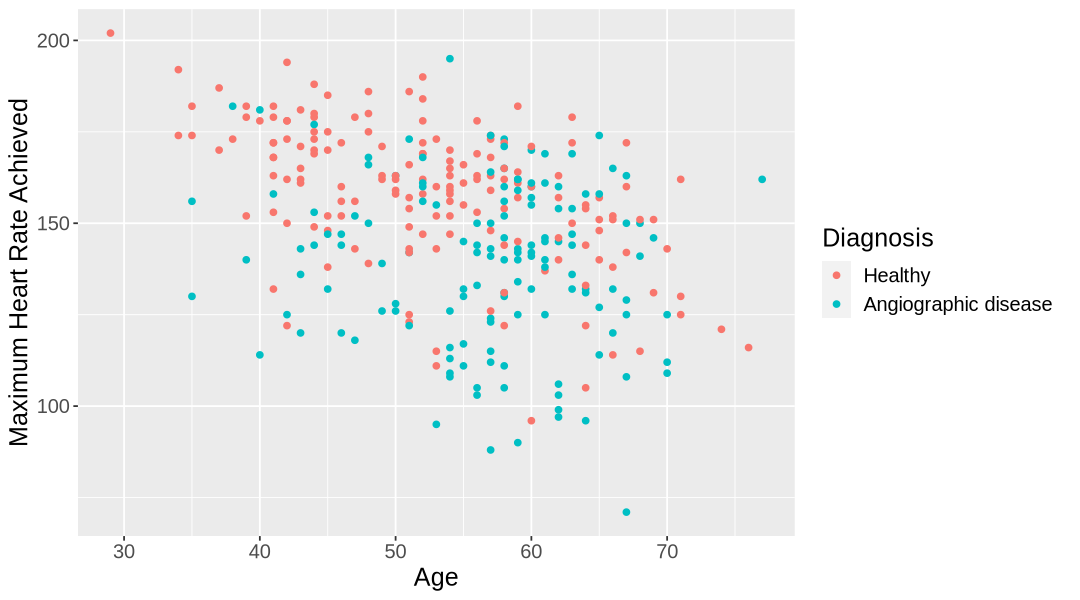

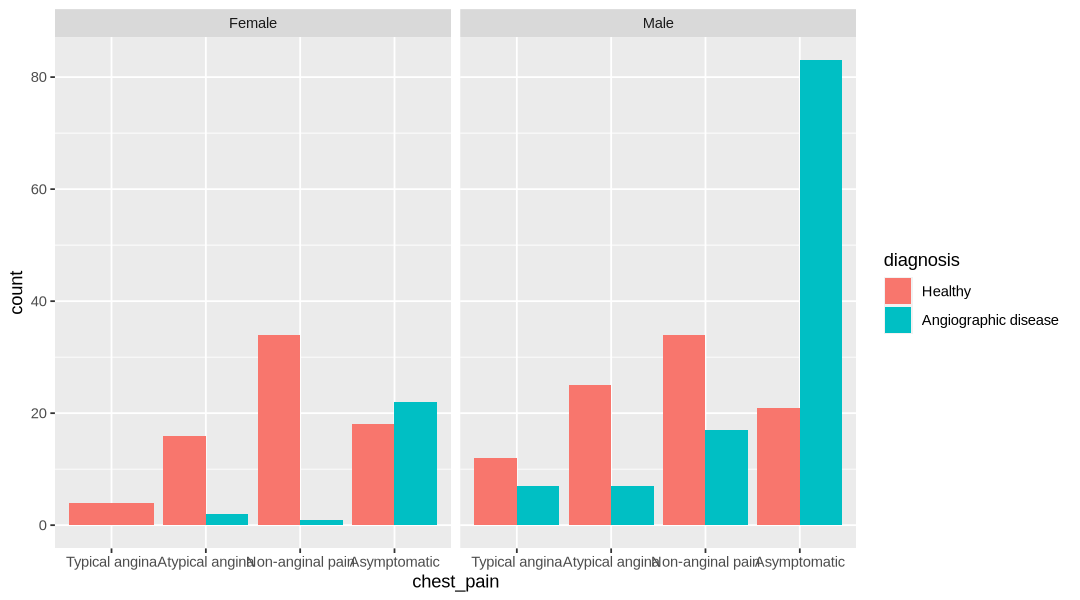

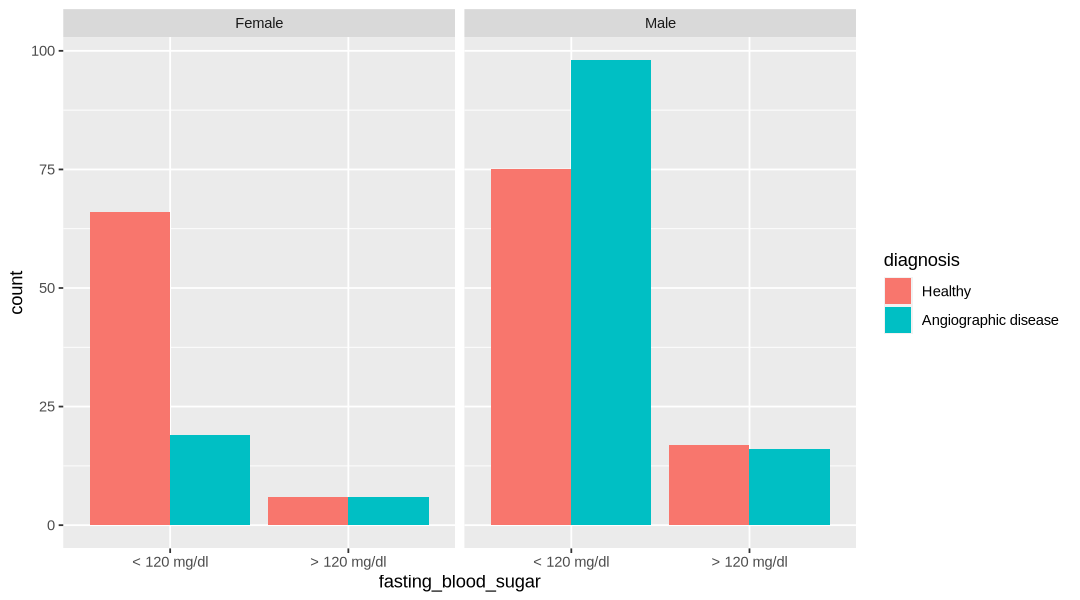

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


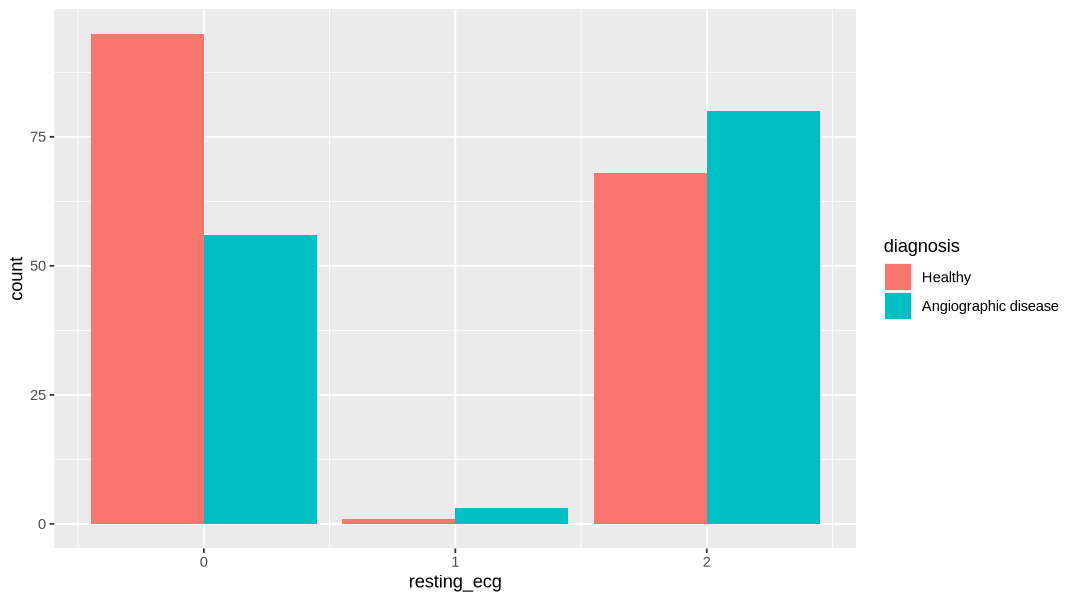

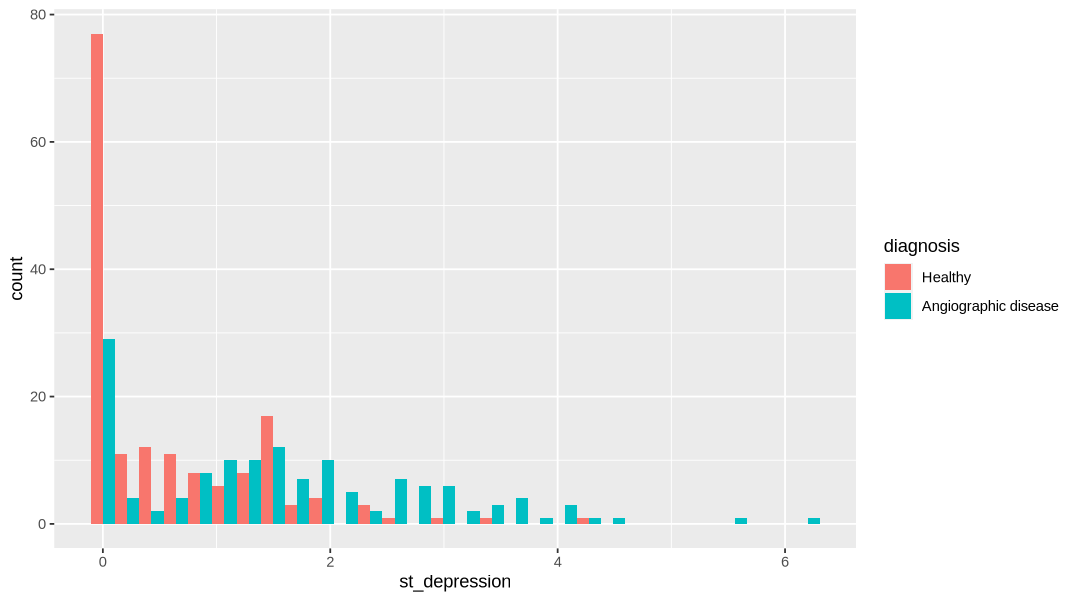

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


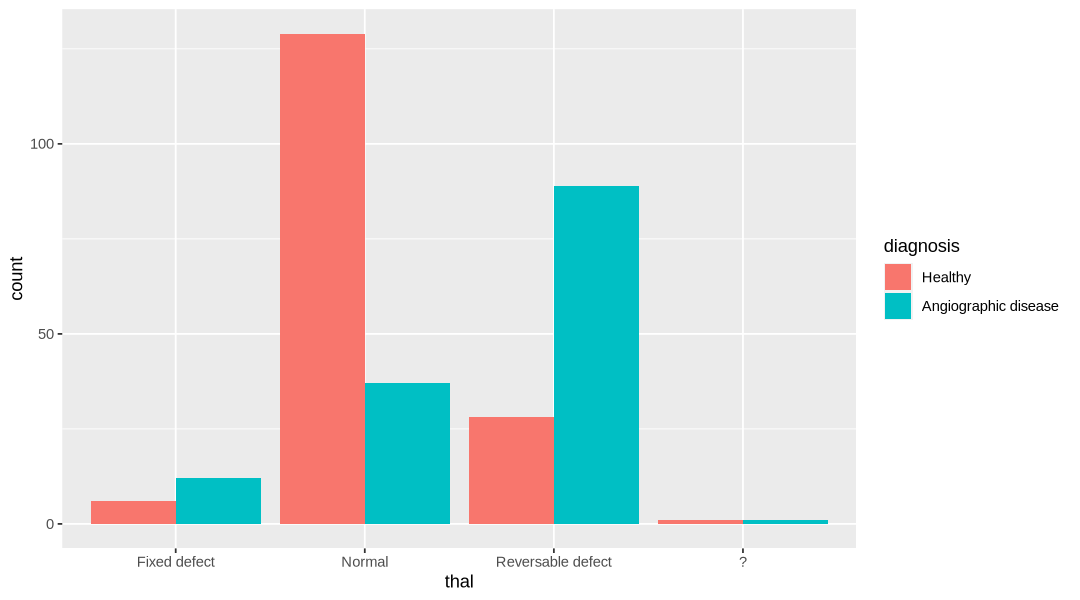

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


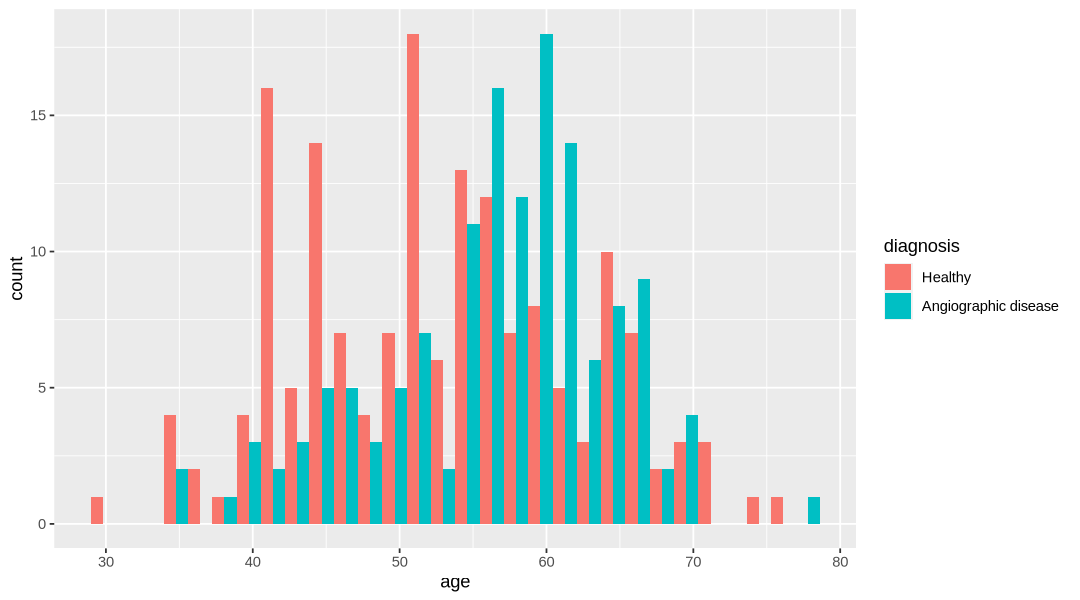

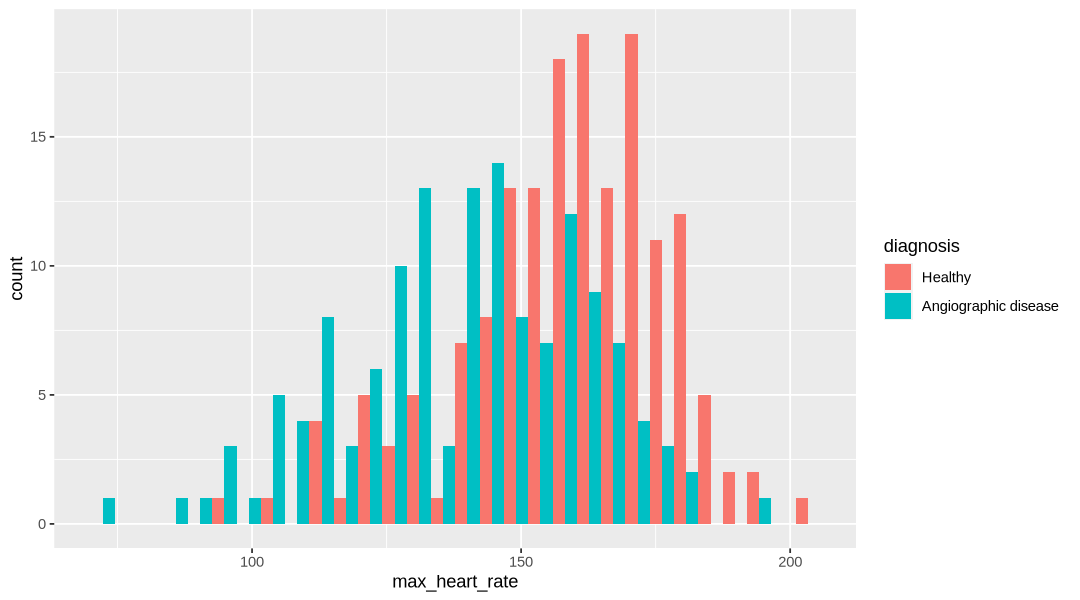

In [54]:
options(repr.plot.width = 9, repr.plot.height = 5)

graph_1 <- data_converted |>
    ggplot(aes(x = age, y = max_heart_rate, colour = diagnosis)) +
    geom_point() +
    labs(x = "Age", y = "Maximum Heart Rate Achieved", colour = "Diagnosis") +
    theme(text = element_text(size = 15))
graph_1

graph_2 <- data_converted |>
    ggplot(aes(x = chest_pain, fill = diagnosis)) +
    geom_bar(position = "dodge") +
    facet_grid(cols = vars(sex))
graph_2

graph_3 <- data_converted |>
    ggplot(aes(x = fasting_blood_sugar, fill = diagnosis)) +
    geom_bar(position = "dodge") +
    facet_grid(cols = vars(sex))
graph_3

graph_4 <- data_converted |>
    ggplot(aes(x = resting_ecg, fill = diagnosis)) +
    geom_bar(position = "dodge") #+
    #facet_grid(cols = vars(sex))

graph_4

graph_5 <- data_converted |>
    ggplot(aes(x = st_depression, fill = diagnosis)) +
    geom_histogram(position = "dodge")
graph_5


graph_6 <- data_converted |>
    ggplot(aes(x = thal, fill = diagnosis)) +
    geom_bar(position = "dodge")
graph_6

graph_age <- data_converted |>
    ggplot(aes(x = age, fill = diagnosis)) +
    geom_histogram(position = "dodge")
graph_age

graph_heart_rate <- data_converted |>
    ggplot(aes(x = max_heart_rate, fill = diagnosis)) +
    geom_histogram(position = "dodge")
graph_heart_rate

From the graphs, the diagnosis of an ndividual appears to have a correlation with maximum heart rate, age, thal, and st_depression.

# Methods:
Explain how you will conduct either your data analysis and which variables/columns you will use. Note - you do not need to use all variables/columns that exist in the raw data set. In fact, that's often not a good idea. For each variable think: is this a useful variable for prediction?
Describe at least one way that you will visualize the results

# Expected outcomes and significance:
What do you expect to find?
What impact could such findings have?
What future questions could this lead to?